<a href="https://colab.research.google.com/github/s-kamireddy/Logistic-Regression-for-Heart-Attack-Risk-Predictiom/blob/main/projects_in_ai_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import required libraries from titanic example
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import Normalizer
from statsmodels.stats.outliers_influence import variance_inflation_factor

import torch
import warnings
warnings.filterwarnings("ignore")

Part 1:
1. Derive the objective function for Logistic Regression using Maximum Likelihood
Estimation (MLE). Do some research on the MAP technique for Logistic Regression,
include your research on how this technique is different from MLE (include citations).

  >Deriving the logit function:

  Starting with the liklihood function:

  $L(w) = Π_{y_i = 1}(p(x^i)) * Π_{y_i = 1}(1-p(x^i)) $

  $= Π(p(x^i)^{y^i} + (1-p(x^i))^{1-y^i})$

  Our goal is to minimize this function, the minimum of the log will occur at the same place so we can take the logarithm and divide by the number of samples:

  $l(w) =\frac{1}{n} log(Π(p(x^i)^{y^i} + (1-p(x^i))^{1-y^i}))$

  $ = \frac{1}{n}Σ( y^i log(p(x^i)) + (1-y^i)log(1-p(x^i)) )$

  $p(x^i) = \frac{1}{1+ e^{-wx^i}} $

  $l(w) = \frac{1}{n}Σ( y^i log( \frac{1}{1+ e^{-wx^i}}) + (1-y^i)log(1-  \frac{1}{1+ e^{-wx^i}}) )$

  $ = \frac{1}{n}Σ( y^i log( \frac{1}{1+ e^{-wx^i}}) + (1-y^i)log( \frac{e^{-wx^i}}{1+ e^{-wx^i}}) )$

  $= \frac{1}{n}Σ( y^i (log( \frac{1}{1+ e^{-wx^i}}) - log(\frac{e^{-wx^i}}{1+ e^{-wx^i}}) ) + log( \frac{e^{-wx^i}}{1+ e^{-wx^i}}) )$
  $= \frac{1}{n}Σ( y^i (log( \frac{1}{1+ e^{-wx^i}}) - log(\frac{e^{-wx^i}}{1+ e^{-wx^i}}) ) ) +  \frac{1}{n}log( \frac{e^{-wx^i}}{1+ e^{-wx^i}})  $
  $ =  \frac{1}{n}Σ( y^i (log( \frac{1}{1+ e^{-wx^i}}) - log(\frac{1}{1+ e^{-wx^i}}) + log(e^{-wx^i})) ) +  \frac{1}{n}log( \frac{e^{-wx^i}}{1+ e^{-wx^i}}) = \frac{1}{n}Σ( y^i ( log(e^{-wx^i})) ) +  \frac{1}{n}log( \frac{e^{-wx^i}}{1+ e^{-wx^i}})  $
  $=  \frac{1}{n}Σ( -y^iwx^i) +  \frac{1}{n}log( \frac{e^{-wx^i}}{1+ e^{-wx^i}})$

  which is our objective function.

  The MAP or Maximum a Postori estimate is different from MLE, because where MLE only considers the liklihood of the sample data, MAP considers both the liklihood of data as well as a prior belief distribution, with the goal being to find the most likley model parameters given the data, rather than minimize a loss function.

  Source: https://www.cs.cornell.edu/courses/cs4780/2015fa/web/lecturenotes/lecturenote06.html

2. Define a machine learning problem you wish to solve using Logistic Regression. Justify
why logistic regression is the best choice and compare it briefly to another linear
classification model (cite your work if this other technique was not covered in class).

The machine learning problem I would like to solve using logistic regression is the liklihood of a heart attack based on a number of demographic and lifestyle factors. This is because the values are binary (heart attack vs. no heart attack) and we want a liklihood as the output of learning (between 0 and 1) making logistic regression a good choice compared to something like linear regression can output any number in the space of real numbers.

3. Discuss how your dataset corresponds to the variables in your equations, highlighting
any assumptions in your derivation from part 1.

Assuming x is [1, x_1, x_2, ... , x_d] and w is of the form [w_0, w_1, w_2, ..., w_d] (where w_0 is the bias and the rest of the w values correspond to weights). $x^i$ corresponds to the lifestyle factors of each individual




Part 2:
----
1. Link to dataset: https://www.kaggle.com/datasets/iamsouravbanerjee/heart-attack-prediction-dataset


In [2]:
#2. EDA
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/heart-attack-prediction-dataset")

print("Path to dataset files:", path)
df = pd.read_csv(path +'/heart_attack_prediction_dataset.csv')

Path to dataset files: /root/.cache/kagglehub/datasets/iamsouravbanerjee/heart-attack-prediction-dataset/versions/2


**Data Dictionary**



In [3]:
df.head()

Patient ID  Age     Sex  Cholesterol Blood Pressure  Heart Rate  Diabetes  \
0    BMW7812   67    Male          208         158/88          72         0   
1    CZE1114   21    Male          389         165/93          98         1   
2    BNI9906   21  Female          324         174/99          72         1   
3    JLN3497   84    Male          383        163/100          73         1   
4    GFO8847   66    Male          318          91/88          93         1   

   Family History  Smoking  Obesity  ...  Sedentary Hours Per Day  Income  \
0               0        1        0  ...                 6.615001  261404   
1               1        1        1  ...                 4.963459  285768   
2               0        0        0  ...                 9.463426  235282   
3               1        1        0  ...                 7.648981  125640   
4               1        1        1  ...                 1.514821  160555   

         BMI  Triglycerides  Physical Activity Days Per Week  \
0  31.251233            286                                0   
1  27.194973            235                                1   
2  28.176571            587                                4   
3  36.464704            378                                3   
4  21.809144            231                                1   

   Sleep Hours Per Day    Country      Continent           Hemisphere  \
0                    6  Argentina  South America  Southern Hemisphere   
1                    7     Canada  North America  Northern Hemisphere   
2                    4     France         Europe  Northern Hemisphere   
3                    4     Canada  North America  Northern Hemisphere   
4                    5   Thailand           Asia  Northern Hemisphere   

   Heart Attack Risk  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 26 columns]

In [4]:
df.shape
df.isna().sum()


Patient ID                         0
Age                                0
Sex                                0
Cholesterol                        0
Blood Pressure                     0
Heart Rate                         0
Diabetes                           0
Family History                     0
Smoking                            0
Obesity                            0
Alcohol Consumption                0
Exercise Hours Per Week            0
Diet                               0
Previous Heart Problems            0
Medication Use                     0
Stress Level                       0
Sedentary Hours Per Day            0
Income                             0
BMI                                0
Triglycerides                      0
Physical Activity Days Per Week    0
Sleep Hours Per Day                0
Country                            0
Continent                          0
Hemisphere                         0
Heart Attack Risk                  0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient ID                       8763 non-null   object 
 1   Age                              8763 non-null   int64  
 2   Sex                              8763 non-null   object 
 3   Cholesterol                      8763 non-null   int64  
 4   Blood Pressure                   8763 non-null   object 
 5   Heart Rate                       8763 non-null   int64  
 6   Diabetes                         8763 non-null   int64  
 7   Family History                   8763 non-null   int64  
 8   Smoking                          8763 non-null   int64  
 9   Obesity                          8763 non-null   int64  
 10  Alcohol Consumption              8763 non-null   int64  
 11  Exercise Hours Per Week          8763 non-null   float64
 12  Diet                

In [6]:
df.describe() #dataset stats

Age  Cholesterol   Heart Rate     Diabetes  Family History  \
count  8763.000000  8763.000000  8763.000000  8763.000000     8763.000000   
mean     53.707977   259.877211    75.021682     0.652288        0.492982   
std      21.249509    80.863276    20.550948     0.476271        0.499979   
min      18.000000   120.000000    40.000000     0.000000        0.000000   
25%      35.000000   192.000000    57.000000     0.000000        0.000000   
50%      54.000000   259.000000    75.000000     1.000000        0.000000   
75%      72.000000   330.000000    93.000000     1.000000        1.000000   
max      90.000000   400.000000   110.000000     1.000000        1.000000   

           Smoking      Obesity  Alcohol Consumption  Exercise Hours Per Week  \
count  8763.000000  8763.000000          8763.000000              8763.000000   
mean      0.896839     0.501426             0.598083                10.014284   
std       0.304186     0.500026             0.490313                 5.783745   
min       0.000000     0.000000             0.000000                 0.002442   
25%       1.000000     0.000000             0.000000                 4.981579   
50%       1.000000     1.000000             1.000000                10.069559   
75%       1.000000     1.000000             1.000000                15.050018   
max       1.000000     1.000000             1.000000                19.998709   

       Previous Heart Problems  Medication Use  Stress Level  \
count              8763.000000     8763.000000   8763.000000   
mean                  0.495835        0.498345      5.469702   
std                   0.500011        0.500026      2.859622   
min                   0.000000        0.000000      1.000000   
25%                   0.000000        0.000000      3.000000   
50%                   0.000000        0.000000      5.000000   
75%                   1.000000        1.000000      8.000000   
max                   1.000000        1.000000     10.000000   

       Sedentary Hours Per Day         Income          BMI  Triglycerides  \
count              8763.000000    8763.000000  8763.000000    8763.000000   
mean                  5.993690  158263.181901    28.891446     417.677051   
std                   3.466359   80575.190806     6.319181     223.748137   
min                   0.001263   20062.000000    18.002337      30.000000   
25%                   2.998794   88310.000000    23.422985     225.500000   
50%                   5.933622  157866.000000    28.768999     417.000000   
75%                   9.019124  227749.000000    34.324594     612.000000   
max                  11.999313  299954.000000    39.997211     800.000000   

       Physical Activity Days Per Week  Sleep Hours Per Day  Heart Attack Risk  
count                      8763.000000          8763.000000        8763.000000  
mean                          3.489672             7.023508           0.358211  
std                           2.282687             1.988473           0.479502  
min                           0.000000             4.000000           0.000000  
25%                           2.000000             5.000000           0.000000  
50%                           3.000000             7.000000           0.000000  
75%                           5.000000             9.000000           1.000000  
max                           7.000000            10.000000           1.000000

In [7]:
df.describe(include=['O'])

Patient ID   Sex Blood Pressure     Diet  Country Continent  \
count        8763  8763           8763     8763     8763      8763   
unique       8763     2           3915        3       20         6   
top       BMW7812  Male         146/94  Healthy  Germany      Asia   
freq            1  6111              8     2960      477      2543   

                 Hemisphere  
count                  8763  
unique                    2  
top     Northern Hemisphere  
freq                   5660

In [8]:
df["Heart Attack Risk"].value_counts(normalize=True)

Heart Attack Risk
0    0.641789
1    0.358211
Name: proportion, dtype: float64

In [9]:

# Convert categorical data to numerical data using cat.codes
df['Sex'] = df['Sex'].astype('category')
df['Sex'] = df['Sex'].cat.codes
df['Exercise Hours Per Week'] = df['Exercise Hours Per Week'].astype('category')
df['Exercise Hours Per Week'] = df['Exercise Hours Per Week'].cat.codes
df['Diet'] = df['Diet'].astype('category')
df['Diet'] = df['Diet'].cat.codes
df['Country'] = df['Country'].astype('category')
df['Country'] = df['Country'].cat.codes
df['Continent'] = df['Continent'].astype('category')
df['Continent'] = df['Continent'].cat.codes
df['Hemisphere'] = df['Hemisphere'].astype('category')
df['Hemisphere'] = df['Hemisphere'].cat.codes

#convert blood pressure to a simple numeric value using Mean Arterial Blood pressure formula
def bp_value(str):
  str = str.split('/')
  return (float(str[0])+ (2*float(str[1])))/3

df['Blood Pressure'] = df['Blood Pressure'].map(bp_value)

#remove patient ID
df.drop('Patient ID', axis=1, inplace=True)



Mean Arterial Blood Pressure formula source: https://clinicalview.gehealthcare.com/white-paper/measuring-mean-arterial-pressure-choosing-most-accurate-method

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8763 non-null   int64  
 1   Sex                              8763 non-null   int8   
 2   Cholesterol                      8763 non-null   int64  
 3   Blood Pressure                   8763 non-null   float64
 4   Heart Rate                       8763 non-null   int64  
 5   Diabetes                         8763 non-null   int64  
 6   Family History                   8763 non-null   int64  
 7   Smoking                          8763 non-null   int64  
 8   Obesity                          8763 non-null   int64  
 9   Alcohol Consumption              8763 non-null   int64  
 10  Exercise Hours Per Week          8763 non-null   int16  
 11  Diet                             8763 non-null   int8   
 12  Previous Heart Probl

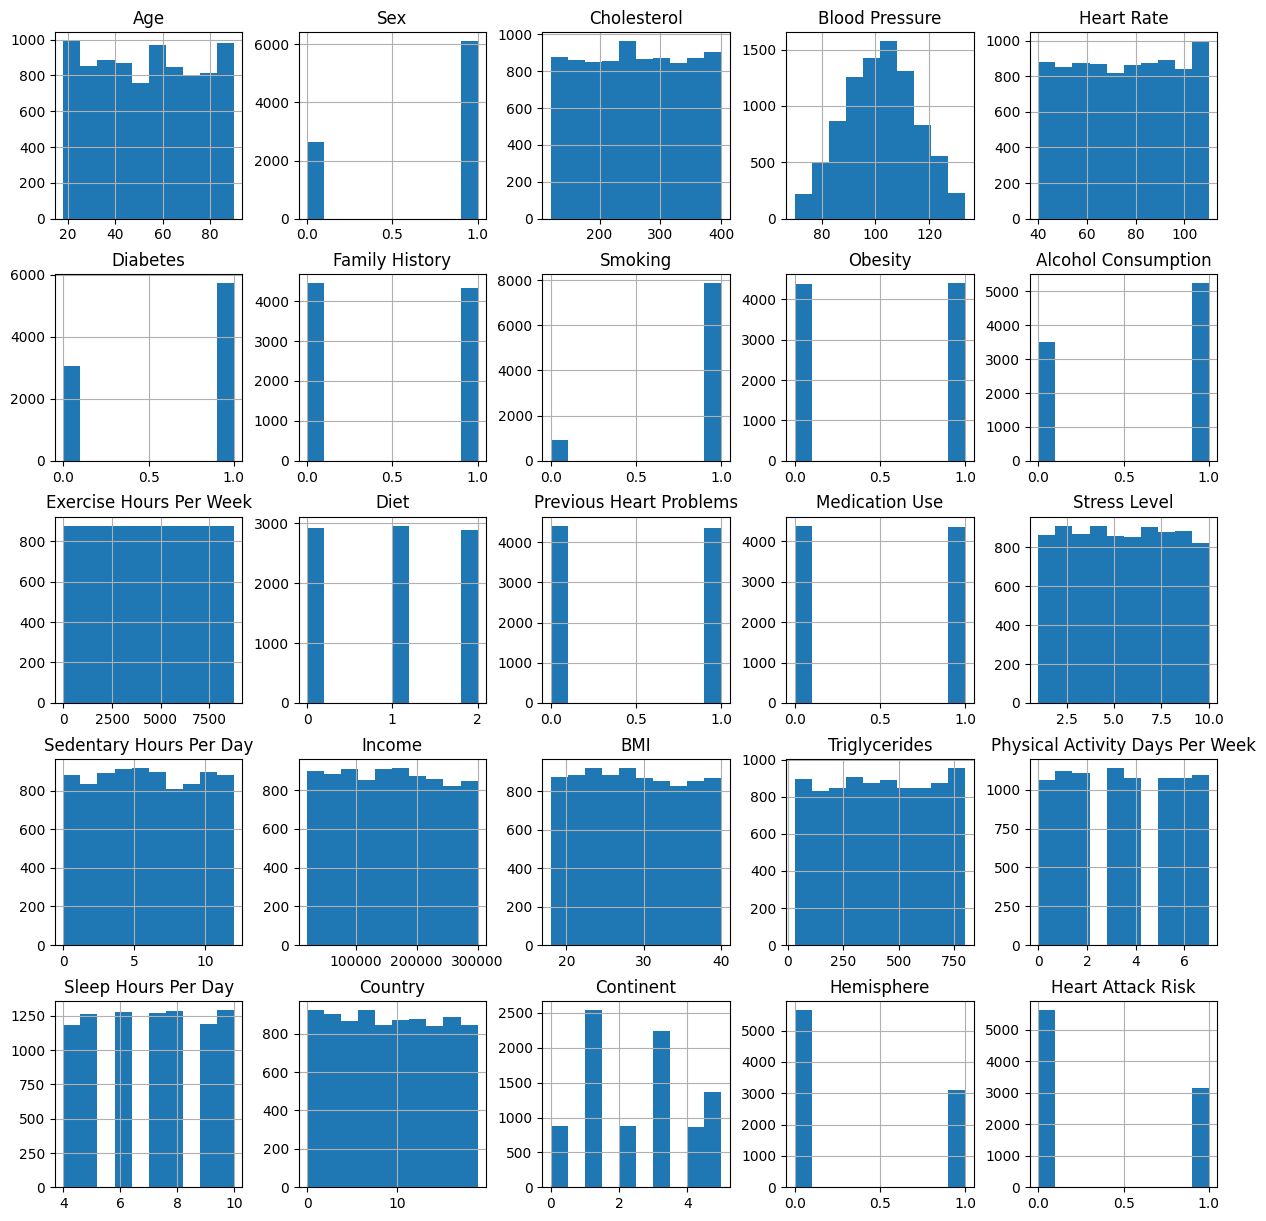

In [11]:
#show distributions
df.hist(figsize=(15,15))
plt.show()

                            feature        VIF
0                               Age   9.124449
1                               Sex   4.750474
2                       Cholesterol  10.738591
3                    Blood Pressure  39.116689
4                        Heart Rate  13.152756
5                          Diabetes   2.845615
6                    Family History   1.963021
7                           Smoking  16.331041
8                           Obesity   1.992428
9               Alcohol Consumption   2.473727
10          Exercise Hours Per Week   3.933757
11                             Diet   2.486000
12          Previous Heart Problems   1.977875
13                   Medication Use   1.987437
14                     Stress Level   4.553042
15          Sedentary Hours Per Day   3.935536
16                           Income   4.760570
17                              BMI  19.302548
18                    Triglycerides   4.401277
19  Physical Activity Days Per Week   3.309257
20           

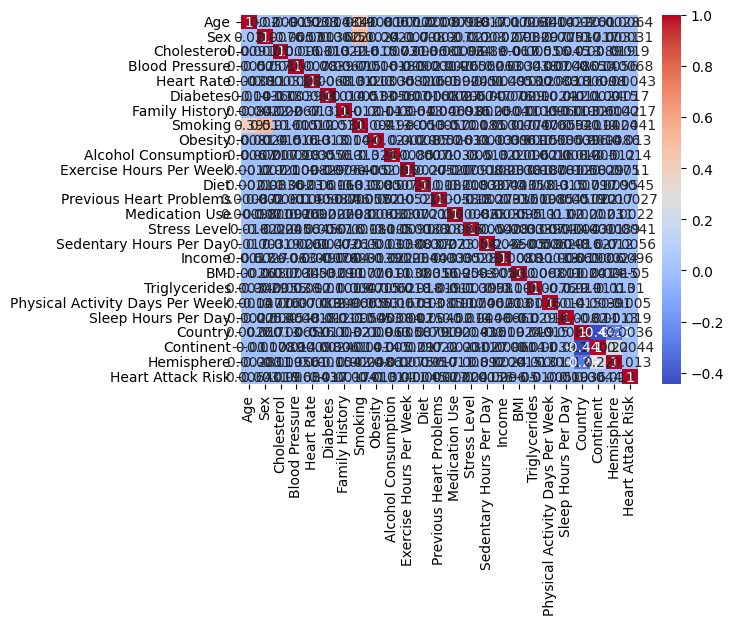

In [12]:
#colinearity
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                          for i in range(len(df.columns))]
print(vif_data)
#high vif values indicate colinearity

#check which variables are colinear with the covariance matrix
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

We see high rates of correlation between country, hemisphere, and continent (as expected) but also between age, sex, and smoking (presumably because older people and males are more likley to smoke). Therefore we will remove the hemisphere, continent, and smoking features in this dataset.

In [13]:
df.drop(['Continent', 'Hemisphere', 'Smoking'], axis=1, inplace=True)

In [14]:
#standardizing the data
for column in df.columns:
    df[column] = (df[column] -
                           df[column].mean()) / df[column].std()

Task 3
----
Now we implement the cost function, as well as the three types of vanilla SGD (batch, minibatch, and stochastic)

In [15]:
def logit_cost(X, Y, y_hat, w):#cost function
  return -torch.mean(Y * torch.log(y_hat) + (1 - Y) * torch.log(1 - y_hat))



In [16]:

def gradient_descent_batch( X, Y ):
  losses= []
  w = torch.zeros(X.shape[1], dtype = torch.float64, requires_grad=True)

  for _ in range(10000):
    z = torch.matmul(X, w)
    y_hat = 1 / (1 + torch.exp(-z))
    loss = logit_cost(X, Y, y_hat,w)
    losses.append(loss.item())

    gradient = torch.matmul(X.T, (y_hat - Y)) / X.shape[0]
    w = w - (gradient * .001)

  print(losses)
  plt.plot(losses)
  plt.show()



  return w


In [17]:
def gradient_descent_minibatch( X, Y ):
  losses= []
  w = torch.zeros(X.shape[1], dtype = torch.float64, requires_grad=True)
  xbatches = []
  ybatches = []
  for i in range(0, 69):
    xbatches.append(X[i:i+127])
    ybatches.append(Y[i:i+127])


  for i in range(100000):
    x_batch = xbatches[i % len(xbatches)]
    y_batch = ybatches[i % len(ybatches)]
    z = torch.matmul(x_batch, w)
    y_hat = 1 / (1 + torch.exp(-z))

    Z = torch.matmul(X, w)
    Y_hat = 1 / (1 + torch.exp(-Z))
    loss = logit_cost(X, Y, Y_hat, w)
    losses.append(loss.item())

    gradient = torch.matmul(x_batch.T, (y_hat - y_batch)) / x_batch.shape[0]
    w = w - (gradient * .0001)

  print(losses)
  plt.plot(losses)
  plt.show()



  return w

In [38]:
def gradient_descent_stochastic( X, Y ):
  losses= []
  w = torch.zeros(X.shape[1], dtype = torch.float64, requires_grad=True)

  for _ in range(1000):
    idx = np.random.randint(0, X.shape[0])
    x = X[idx]
    y = Y[idx]
    z = torch.matmul(x, w)
    y_hat = 1 / (1 + torch.exp(-z))
    y_hat_all = 1 / (1 + torch.exp(-torch.matmul(X, w)))

    Z = torch.matmul(X, w)
    Y_hat = 1 / (1 + torch.exp(-Z))
    loss = logit_cost(X, Y, Y_hat, w)
    losses.append(loss.item())


    gradient =x.T *(y_hat - y)
    w = w - (gradient * .01)

  print(losses)
  plt.plot(losses)
  plt.show()



  return w

def test_error(X, Y, W):
  

In [19]:
def test_error(X, Y, W):
  z = torch.matmul(X, W)
  y_hat = 1 / (1 + torch.exp(-z))

  error = logit_cost(X, Y, y_hat, W)
  return error.item()

In [20]:
Y = df['Heart Attack Risk'].values
X = df.drop('Heart Attack Risk', axis=1).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [21]:
x_train = torch.tensor(X_train)
x_train = torch.cat((torch.ones(x_train.shape[0], 1), x_train), dim=1)
y_train = torch.tensor(Y_train, dtype = torch.float64)
x_test = torch.tensor(X_test)
x_test = torch.cat((torch.ones(x_test.shape[0], 1), x_test), dim=1)
y_test = torch.tensor(Y_test, dtype = torch.float64)

In [22]:
x_train.dtype

torch.float64

Task 4: Optimization Techniques and Advanced Comparision

In [23]:
def gradient_descent_stochastic_momentum( X, Y ):
  losses = []
  w = torch.zeros(X.shape[1], dtype = torch.float64, requires_grad=True)
  v_w = torch.zeros(X.shape[1], dtype = torch.float64, requires_grad=True)

  alpha = 0.001
  beta = 0.9
  v = 0

  for _ in range(100000):
    idx = np.random.randint(0, X.shape[0])
    x = X[idx]
    y = Y[idx]
    z = torch.matmul(x, w)
    y_hat = 1/(1+torch.exp(-z))

    Z = torch.matmul(X, w)
    Y_hat = 1 / (1 + torch.exp(-Z))
    loss = logit_cost(X, Y, Y_hat, w)
    losses.append(loss.item())

    gradient = x.T *(y_hat - y)

    v_w = beta * v_w + (1 - beta) * gradient
    w = w - (alpha * v_w)

  print(losses)
  plt.plot(losses)
  plt.show()



  return w





Nesterov: https://medium.com/@piyushkashyap045/understanding-nesterov-accelerated-gradient-nag-340c53d64597


In [37]:
def gradient_descent_stochastic_nesterov( X, Y ):
  losses = []
  w = torch.zeros(X.shape[1], dtype = torch.float64, requires_grad=True)
  v_w = torch.zeros(X.shape[1], dtype = torch.float64, requires_grad=True)

  alpha = 0.001
  beta = 0.5


  for _ in range(100000):
    idx = np.random.randint(0, X.shape[0])
    x = X[idx]
    y = Y[idx]

    Z = torch.matmul(X, w)
    Y_hat = 1 / (1 + torch.exp(-Z))
    loss = logit_cost(X, Y, Y_hat, w)
    losses.append(loss.item())

    w_lookahead = w - beta * v_w
    z = torch.matmul(x, w_lookahead)
    y_hat = 1/(1+torch.exp(-z))
    gradient = x.T *(y_hat - y)

    v_w = beta * v_w + (alpha) * gradient
    w = w - v_w

  print(losses)
  plt.plot(losses)
  plt.show()



  return w

Adagrad resource: https://medium.com/@brijesh_soni/understanding-the-adagrad-optimization-algorithm-an-adaptive-learning-rate-approach-9dfaae2077bb

In [36]:
def gradient_descent_stochastic_adagrad( X, Y ):
  losses = []
  w = torch.zeros(X.shape[1], dtype = torch.float64, requires_grad=True)

  epsilon = 0.000000001

  accumulated_gradient = torch.zeros(X.shape[1], dtype = torch.float64)
  for _ in range(100000):
    idx = np.random.randint(0, X.shape[0])
    x = X[idx]
    y = Y[idx]

    z = torch.matmul(x, w)
    y_hat = 1/(1+torch.exp(-z))

    Z = torch.matmul(X, w)
    Y_hat = 1 / (1 + torch.exp(-Z))
    loss = logit_cost(X, Y, Y_hat, w)
    losses.append(loss.item())

    gradient = x.T* (y_hat - y)

    accumulated_gradient = accumulated_gradient + gradient**2

    lr = 0.0001

    w = w - (lr* gradient / (torch.sqrt(accumulated_gradient) + epsilon))

  print(losses)
  plt.plot(losses)
  plt.show()



  return w






Now we use Precision, Recall and F1 Score to evaluate

In [43]:
def evaluate(X, Y, W):
  #precision
  Z = torch.matmul(X, W)
  Y_hat = 1 / (1 + torch.exp(-Z))
  Y_hat = (Y_hat > 0.5).float()

  TP = torch.sum((Y_hat == 1) & (Y == 1)).float()
  FP = torch.sum((Y_hat == 1) & (Y == 0)).float()
  FN = torch.sum((Y_hat == 0) & (Y == 1)).float()

  precision = TP / (TP + FP) if (TP + FP) != 0 else 0
  recall = TP / (TP + FN) if (TP + FN) != 0 else 0
  f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
  print("Precision: ", precision)
  print("Recall: ", recall)
  print("F1 Score: ", f1_score)

Evaluating the Vanilla SGD Algorithms, as well as stochastic momentum, stochastic nesterov, and adagrad

[0.6931471805599454, 0.6928939014013719, 0.6926407491431158, 0.6923877237215372, 0.6921348250730109, 0.6918820531339269, 0.6916294078406905, 0.6913768891297218, 0.6911244969374559, 0.6908722312003439, 0.690620091854851, 0.6903680788374582, 0.6901161920846619, 0.6898644315329736, 0.68961279711892, 0.6893612887790433, 0.6891099064499011, 0.6888586500680663, 0.6886075195701272, 0.6883565148926879, 0.6881056359723675, 0.6878548827458013, 0.6876042551496394, 0.6873537531205478, 0.6871033765952085, 0.6868531255103185, 0.6866029998025912, 0.6863529994087549, 0.6861031242655541, 0.6858533743097491, 0.6856037494781159, 0.6853542497074462, 0.685104874934548, 0.6848556250962444, 0.6846065001293751, 0.6843574999707954, 0.684108624557377, 0.683859873826007, 0.6836112477135886, 0.6833627461570416, 0.6831143690933014, 0.6828661164593197, 0.682617988192064, 0.6823699842285187, 0.6821221045056836, 0.6818743489605752, 0.681626717530226, 0.6813792101516852, 0.6811318267620176, 0.680884567298305, 0.680637

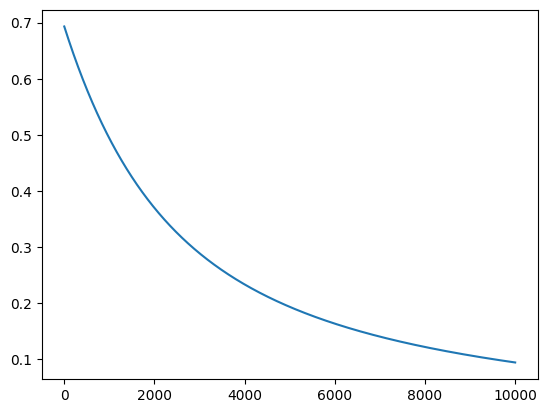

Precision:  0
Recall:  0
F1 Score:  0


In [44]:
w = gradient_descent_batch(x_train, y_train)
evaluate(x_test, y_test, w)

In [ ]:
w = gradient_descent_minibatch(x_train, y_train)
evaluate(x_test, y_test, w)

In [ ]:
w = gradient_descent_stochastic(x_train, y_train)
evaluate(x_test, y_test, w)

In [ ]:
w = gradient_descent_stochastic_momentum(x_train, y_train)
evaluate(x_test, y_test, w)

[0.6931471805599454, 0.6924368086721763, 0.6915040078131014, 0.6913902261348105, 0.690827172798734, 0.6910213910832761, 0.6915381060138048, 0.691232847434821, 0.6904673410926764, 0.6893858815280002, 0.6893318381796316, 0.6888273320436137, 0.688952515781737, 0.688356233552267, 0.6875597242027556, 0.6875757976740078, 0.6879874871184718, 0.6885935614220262, 0.6883703903706703, 0.6875101857974284, 0.6863180299449145, 0.685172175801703, 0.68503321955287, 0.685413752030476, 0.6849699380751322, 0.6842498340825549, 0.6832666317131786, 0.6820928884853878, 0.6807690917804918, 0.679426593644088, 0.6781983383560442, 0.6769091033494977, 0.6756266219429556, 0.6754076242891455, 0.6746367108791752, 0.6746909599386784, 0.674211627023552, 0.674453237607258, 0.6739781318029666, 0.6732871764784933, 0.6722943426180065, 0.6722053956760909, 0.6715265811399297, 0.6715795793928238, 0.6709701620541889, 0.6701457492748875, 0.6690626232975584, 0.668901349852665, 0.669246441949674, 0.6687420005742466, 0.6679849697

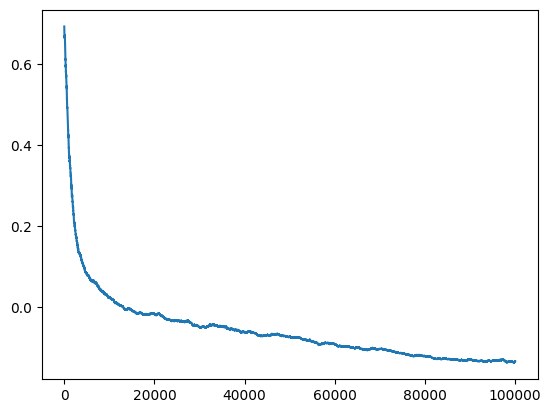

Precision:  tensor(nan)
Recall:  tensor(nan)
F1 Score:  tensor(nan)


In [41]:
w = gradient_descent_stochastic_nesterov(x_train, y_train)
evaluate(x_test, y_test, w)

[0.6931471805599454, 0.6930929529807707, 0.6931181700577603, 0.6930888268333963, 0.6931058471994598, 0.6931256579151943, 0.6930929392999374, 0.6931104608052565, 0.6930895190381123, 0.6930675249122694, 0.6930820193250458, 0.6930666245829975, 0.6930767074181508, 0.6930861887100468, 0.6930704890918424, 0.6930815201130951, 0.693092423656353, 0.6930807379671872, 0.6930665292235028, 0.6930536800973943, 0.6930420151207201, 0.6930294231164257, 0.6930389750383047, 0.6930298030607781, 0.6930359211984821, 0.6930427079772319, 0.6930345165712941, 0.6930429746215946, 0.6930507261492511, 0.693038367686537, 0.6930273764245355, 0.6930351815789502, 0.6930278901445031, 0.6930361930309301, 0.6930270664262989, 0.6930179075539, 0.6930085876561195, 0.6930007732097094, 0.6929889818844079, 0.6929809285823717, 0.6929695738807062, 0.6929600168227715, 0.6929504282243855, 0.6929566941979921, 0.692964034671657, 0.6929550934526217, 0.6929597696502946, 0.6929655703798872, 0.692971164071292, 0.6929763715323105, 0.6929

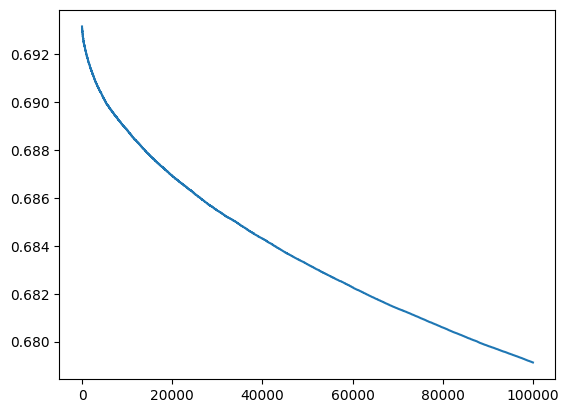

Precision:  tensor(nan)
Recall:  tensor(nan)
F1 Score:  tensor(nan)


In [42]:
w = gradient_descent_stochastic_adagrad(x_train, y_train)
evaluate(x_test, y_test, w)

Momentum had a faster convergence, through nesterov was overall the best algorithm to use since the "look ahead" component dampened oscillations. The larg cumulative gradient of adagrad was finnicky and led to divergence.